In [13]:
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

a4_dims = (11,17)

In [16]:
filename = "data//data.json"

with open(filename) as datafile:
    data = json.load(datafile)

FileNotFoundError: [Errno 2] No such file or directory: 'data//data.json'

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.head()

In [14]:
from ih_core.ih_engine_functions import strTime_to_unixTime
dateFormat = '%Y-%m-%dT%H:%M:%S.%fZ'

In [ ]:
strTsime_to_unixTime

In [15]:
strTime_to_unixTime(df["@timestamp"][0], dateFormat)

NameError: name 'df' is not defined

In [18]:
df["@timestamp"].apply(lambda row: strTime_to_unixTime(row, dateFormat))

0       1525651248000
1       1527488148000
2       1526305248000
3       1525178448000
4       1526305848000
5       1527010848000
6       1525177848000
7       1525651548000
8       1527489048000
9       1527488748000
10      1525178148000
11      1527011448000
12      1526306148000
13      1525651848000
14      1525652148000
15      1525179048000
16      1527488448000
17      1526307048000
18      1527489648000
19      1525178748000
20      1527011148000
21      1525652448000
22      1526307348000
23      1527489348000
24      1525179348000
25      1525652748000
26      1527489948000
27      1526307948000
28      1525653048000
29      1527490548000
            ...      
9186    1527427248000
9187    1527426348000
9188    1527428748000
9189    1527429048000
9190    1527429348000
9191    1527428448000
9192    1527430248000
9193    1527429948000
9194    1527429648000
9195    1527433248000
9196    1527433548000
9197    1527433848000
9198    1527434448000
9199    1527434748000
9200    15

doing LSTM research on ecg values

In [7]:
import pandas as pd
csv_data = pd.read_csv('data/ecg_values.csv')
dataset = np.reshape(csv_data, (-1,1))
scaler = MinMaxScaler(feature_range=(0,1))
dataset =  scaler.fit_transform(dataset)


NameError: name 'MinMaxScaler' is not defined

C:\apps\anaconda2\envs\python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/10
 - 2s - loss: 0.0888
Epoch 2/10
 - 1s - loss: 0.0278
Epoch 3/10
 - 1s - loss: 0.0246
Epoch 4/10
 - 1s - loss: 0.0224
Epoch 5/10
 - 1s - loss: 0.0202
Epoch 6/10
 - 1s - loss: 0.0184
Epoch 7/10
 - 1s - loss: 0.0164
Epoch 8/10
 - 1s - loss: 0.0148
Epoch 9/10
 - 1s - loss: 0.0135
Epoch 10/10
 - 1s - loss: 0.0123
Train Score: 112.68 RMSE
Test Score: 112.31 RMSE


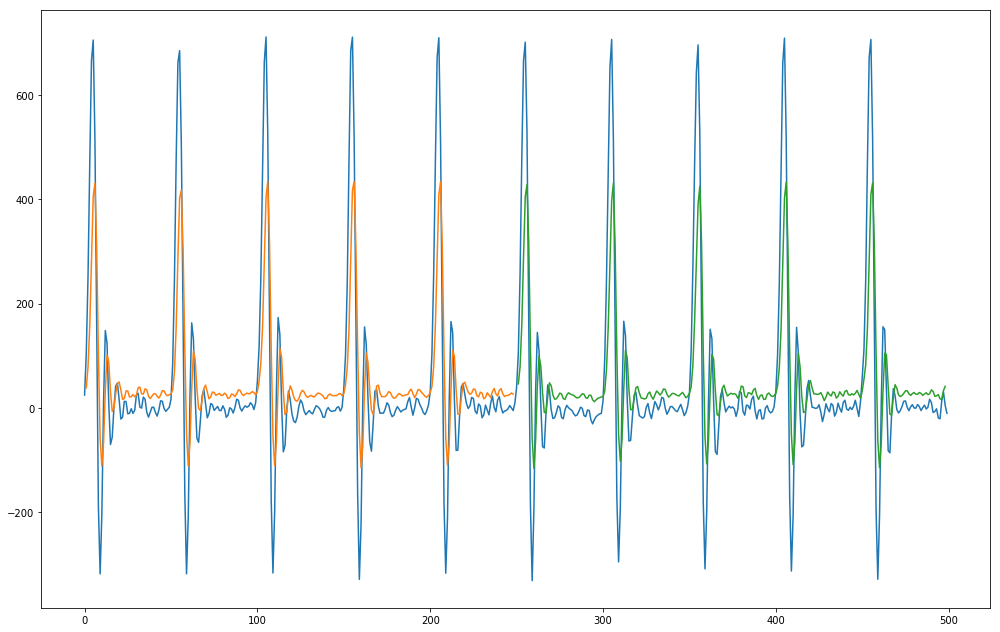

In [8]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
a4_dims = (17,11)

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

n_steps = 1

csv_data = pd.read_csv('data/ecg_values.csv', infer_datetime_format=True)
dataset = np.reshape(csv_data, (-1,1))

scaler = MinMaxScaler(feature_range=(0,1))
dataset =  scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:,:]

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], n_steps, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], n_steps, testX.shape[1]))

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=a4_dims)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

C:\apps\anaconda2\envs\python3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


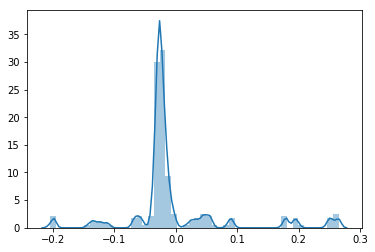

In [9]:
target = model.predict(trainX)
predictor = trainX.reshape(trainX.shape[0], 1)
#testPredict = model.predict(test)
e = predictor - target

import seaborn as sns
sns.distplot(e)
plt.show()

In [ ]:
model.

In [10]:
mu = e.mean()
sd = e.std()
sensitivity = 3.08

ub = mu + sensitivity * sd
lb = mu - sensitivity * sd 

is_anomaly = np.logical_or(e <= lb, e >= ub)
is_anomaly = is_anomaly.reshape(248,)

In [11]:
predictor2 = pd.Series(predictor.reshape(248,))
anomalies = predictor2[is_anomaly]

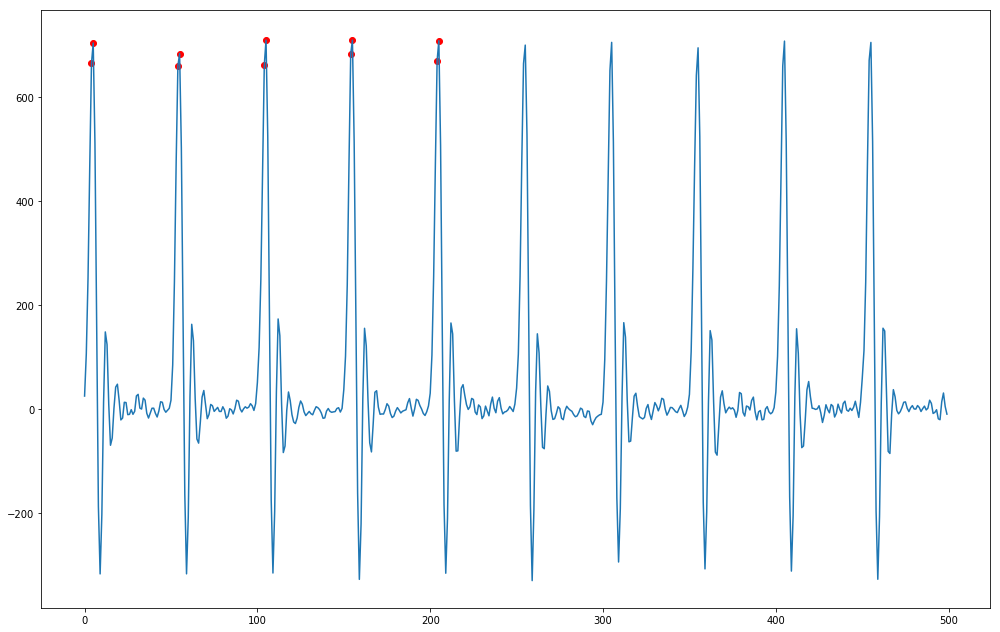

In [12]:
plt.figure(figsize=a4_dims) 
plt.plot(scaler.inverse_transform(dataset))
#plt.plot(trainPredictPlot)
#plt.plot(testPredictPlot)
plt.scatter(np.array(anomalies.index), scaler.inverse_transform(np.array(anomalies).reshape(-1,1)), c='red')
plt.show()